# Stock Price Forecasting using Linear Regression

In this notebook, I am exploring the use of linear regression for stock price forecasting. The workflow involves fetching historical stock data, creating features, training a linear regression model, and evaluating its performance. Visualizations are included to compare actual and predicted stock prices.

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2020-01-02  72.716057  72.776583  71.466797  71.721004  135480400
2020-01-03  72.009132  72.771760  71.783977  71.941343  146322800
2020-01-06  72.582909  72.621646  70.876075  71.127866  118387200
2020-01-07  72.241539  72.849216  72.021223  72.592586  108872000
2020-01-08  73.403648  73.706279  71.943759  71.943759  132079200


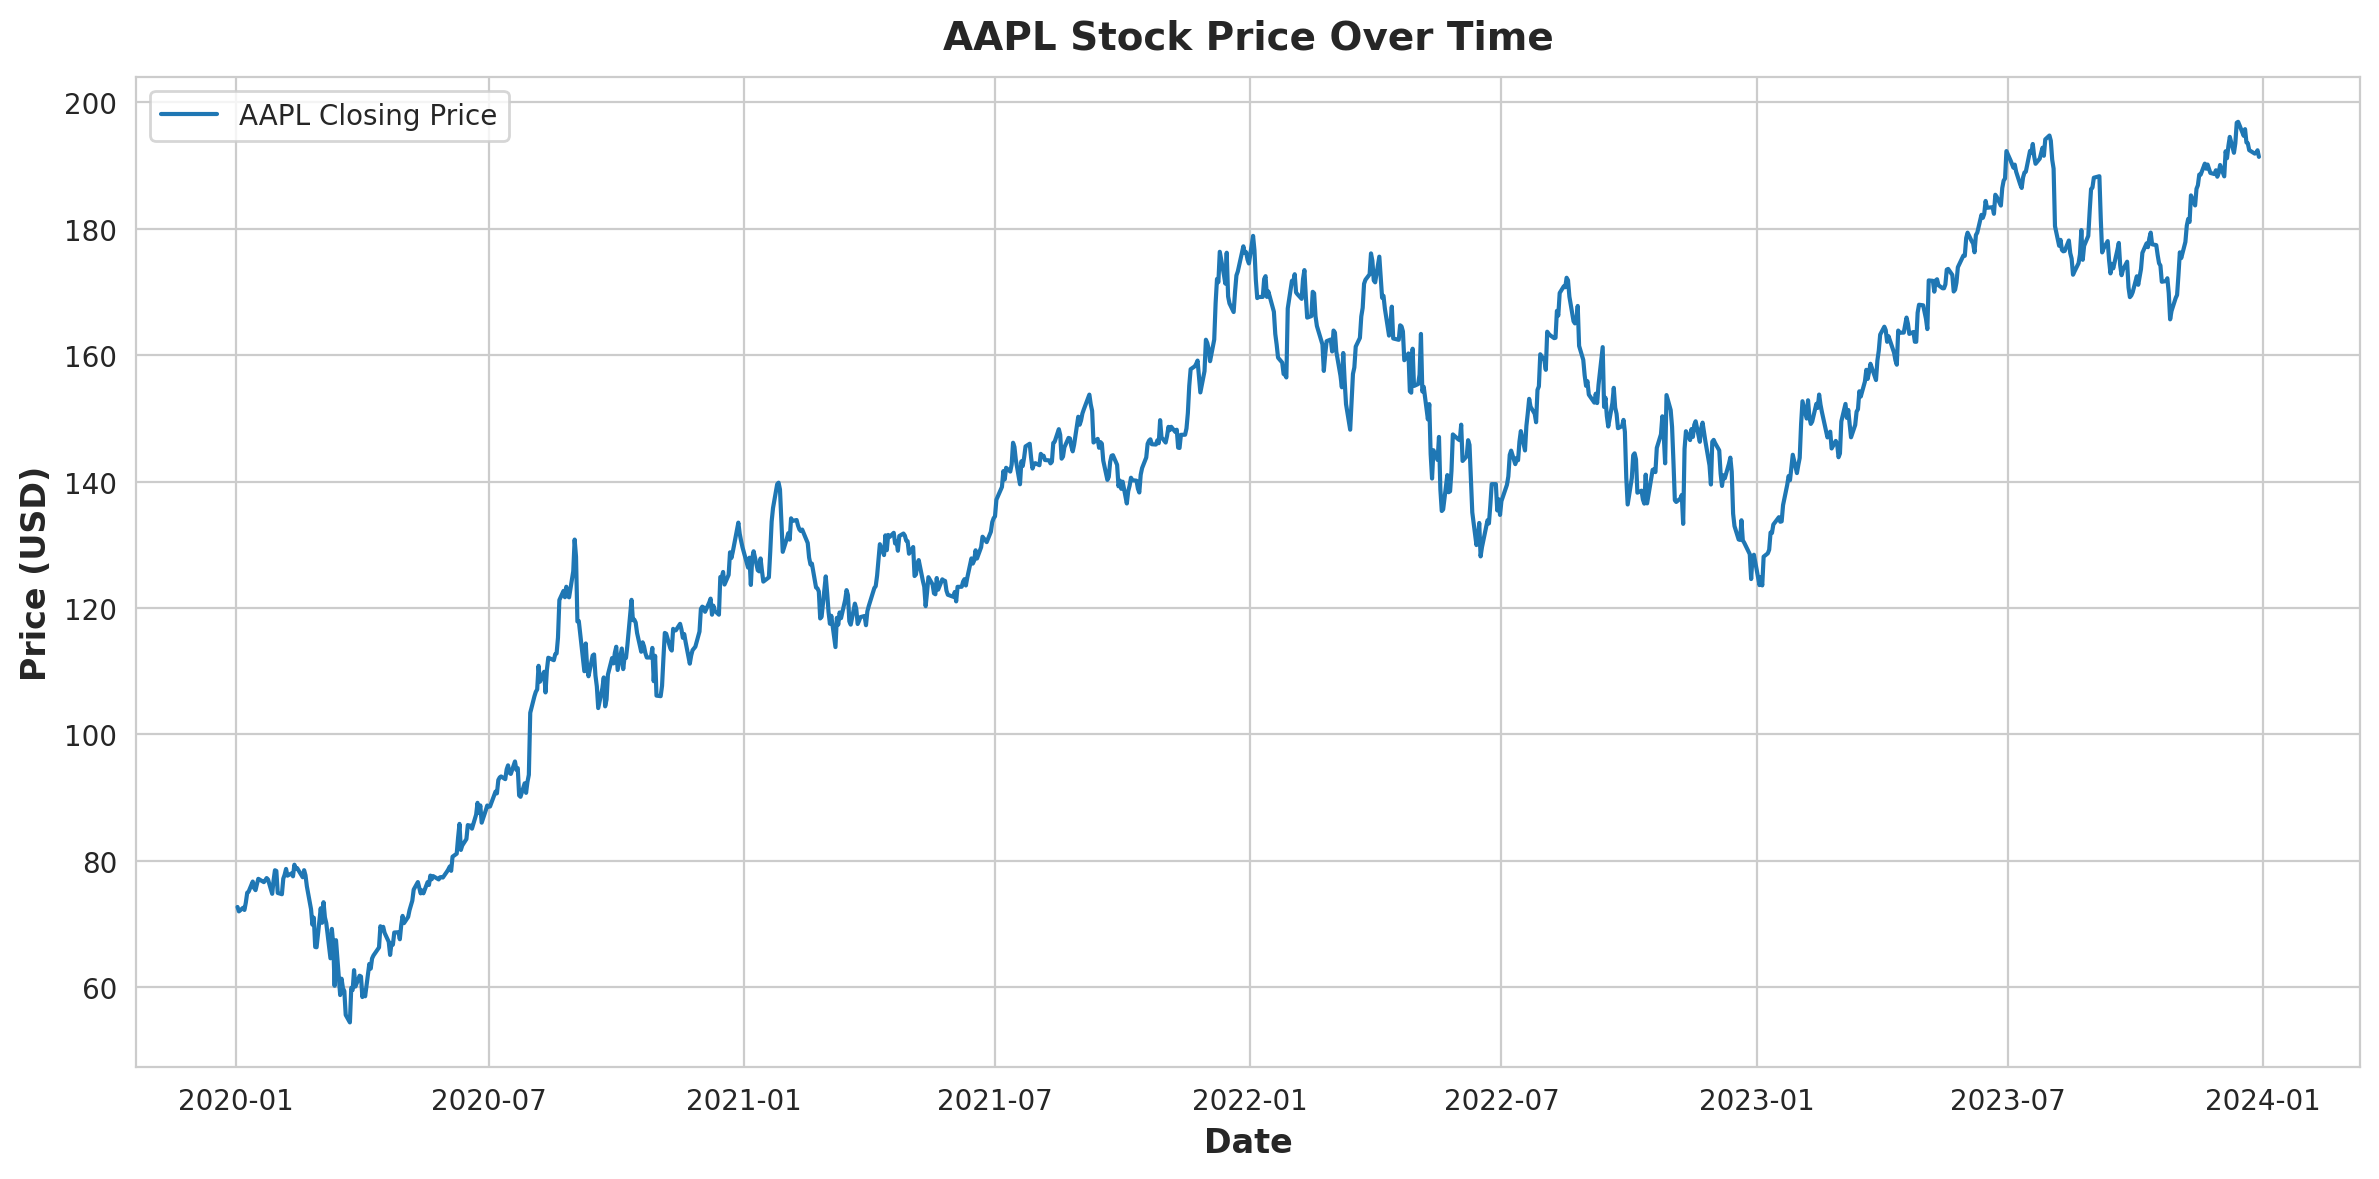

In [1]:
import yfinance as yf  # yahoo finance for historical stock data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set_style("whitegrid")

# Set Matplotlib defaults
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

# Define the stock and time period
ticker = "AAPL"  # Change to any stock symbol you like
start_date = "2020-01-01"
end_date = "2024-01-01"

# Fetch data
data = yf.download(ticker, start=start_date, end=end_date)

# Quick check
print(data.head())

# Plot stock prices over time; closing price
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label=f"{ticker} Closing Price")
plt.title(f"{ticker} Stock Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.legend()
plt.show()

Try a simple linear regression model with only feature the time dummy. Let's call $y$ the prediction and $t$ the time dummy (a label for time instances). The model fits the data with
$$y = b_0 + b_1 \, t\,,$$
where $b_0$ is the intercection (bias) and $b_1$ the weight.

We train the model on the first 80% of data and forecast the next 20%.

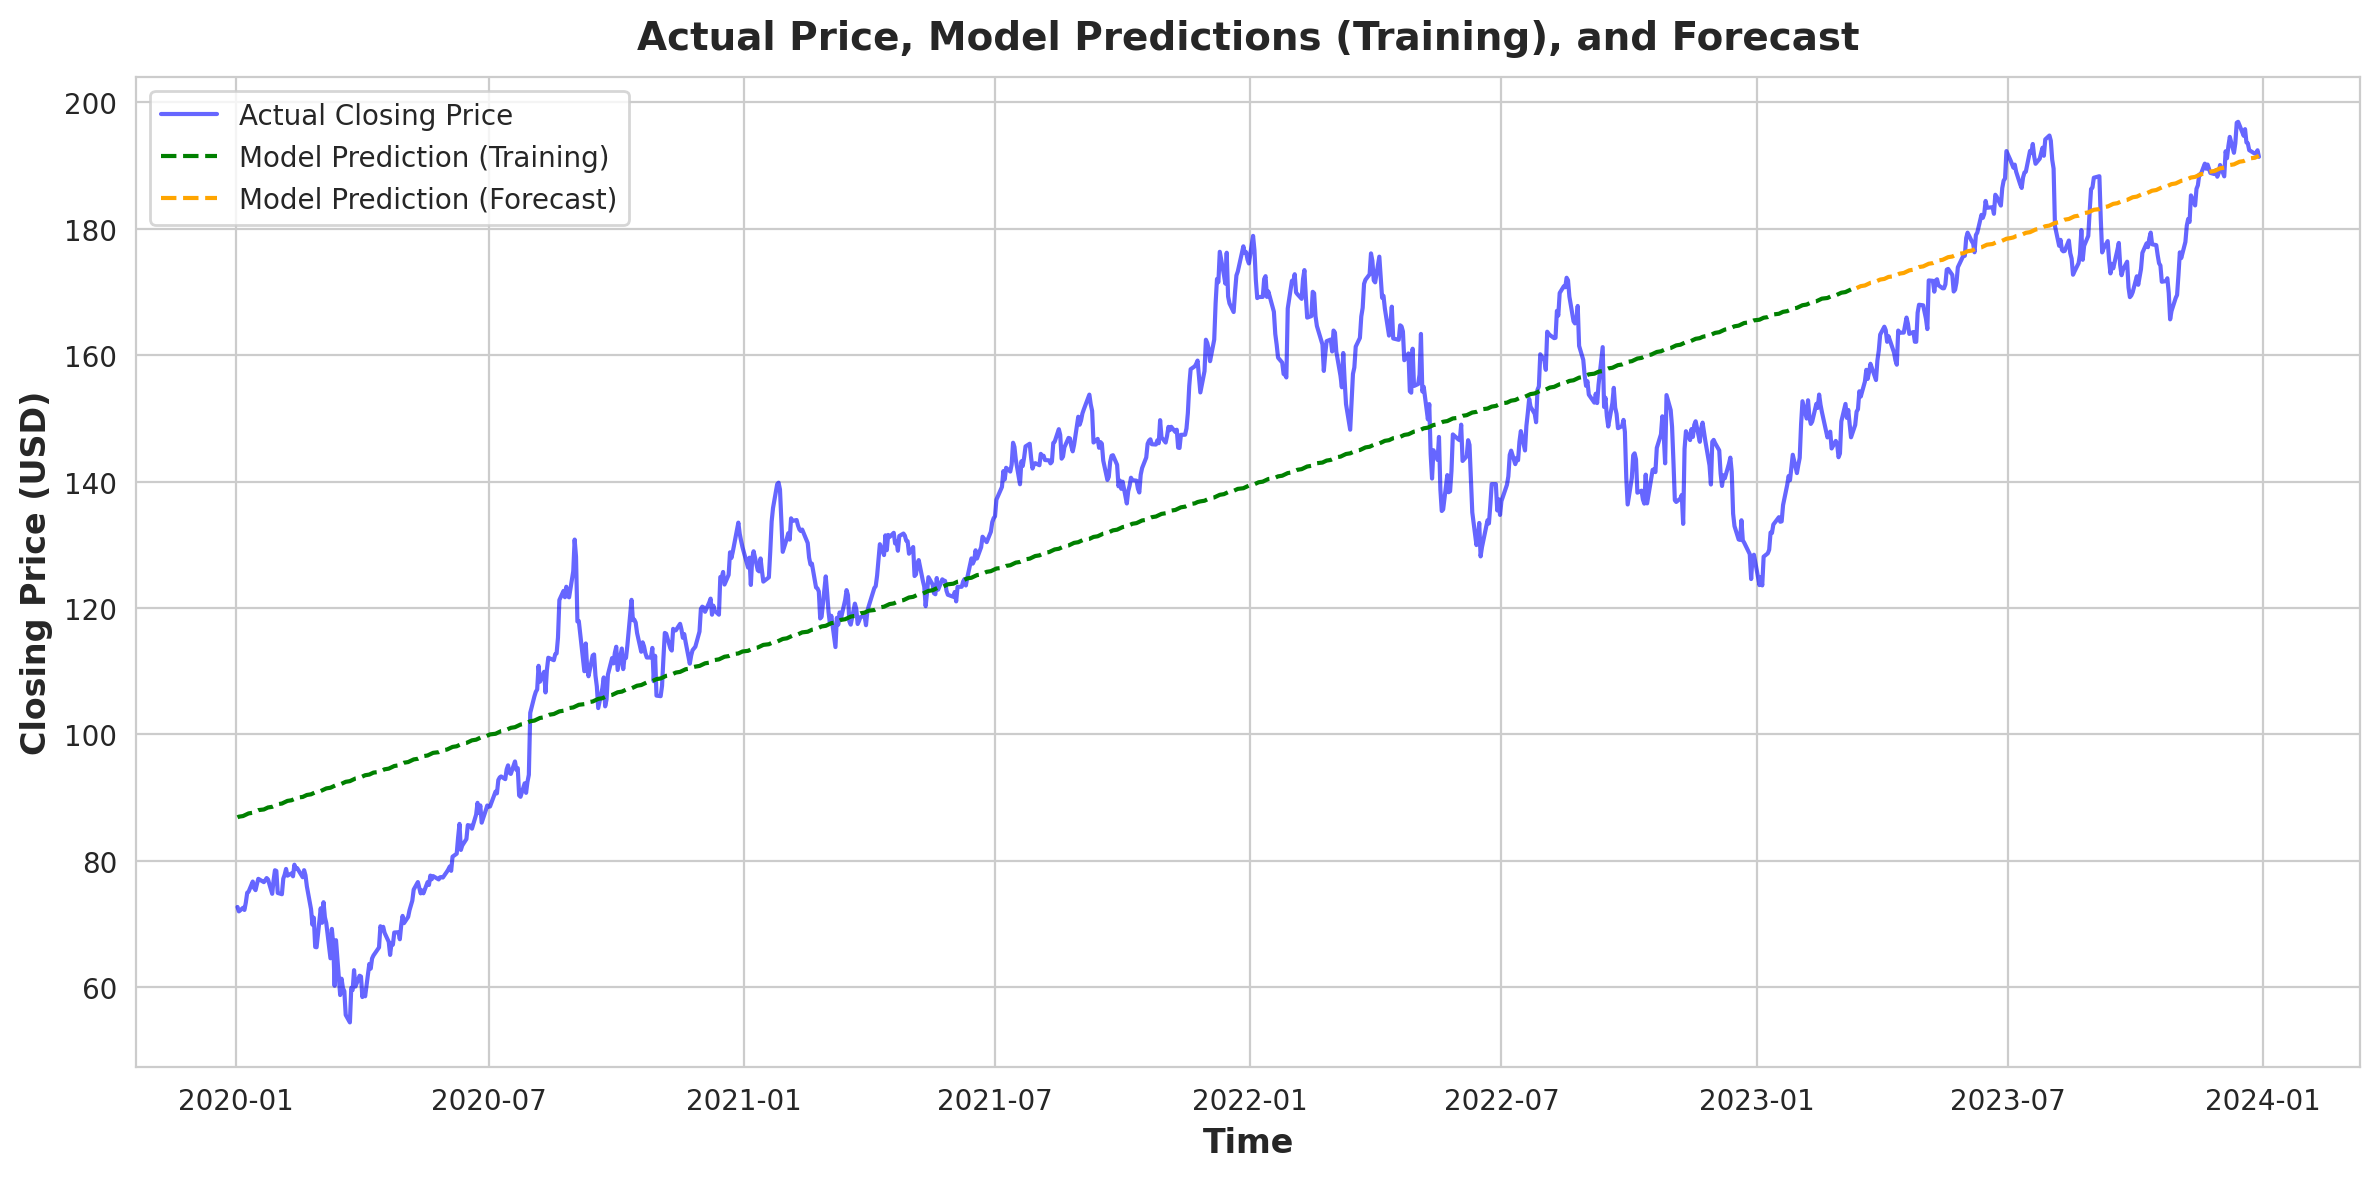

Model evaluation on the test set:
Mean Squared Error (Test): 83.14
Mean Absolute Error (Test): 7.68


In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Ensure `data` is a DataFrame
df = data.copy()

# Create a time dummy (labels for each time point)
time = np.arange(len(df.index))  # Create a sequence of integers for the time index
df['time'] = time

# Create features and target
X = df[['time']]  # Features (time dummy)
y = df['Close']   # Target (closing price)

# Train-test split (80% train, 20% test, no shuffling to preserve time order)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_train_pred = pd.Series(model.predict(X_train).flatten(), index=X_train.index)  # Predictions for training set
y_test_pred = pd.Series(model.predict(X_test).flatten(), index=X_test.index)    # Predictions for testing set

# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))

# Plot the actual closing price
plt.plot(df.index, df['Close'], label="Actual Closing Price", color="blue", alpha=0.6)

# Plot the model's predictions on the training set
plt.plot(X_train.index, y_train_pred, label="Model Prediction (Training)", color="green", linestyle="--")

# Plot the model's predictions on the test set (forecast)
plt.plot(X_test.index, y_test_pred, label="Model Prediction (Forecast)", color="orange", linestyle="--")

# Add labels, title, and legend
plt.title("Actual Price, Model Predictions (Training), and Forecast")
plt.xlabel("Time")
plt.ylabel("Closing Price (USD)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Evaluate the model on the test set
print("Model evaluation on the test set:")
mse = mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
print(f"Mean Squared Error (Test): {mse:.2f}")
print(f"Mean Absolute Error (Test): {mae:.2f}")

Next, try to make the fit more complex by adding Fourier features, which is pairs of $\sin(2\pi k f t)$ and $\cos(2\pi k f t)$, where $k$ is the order and $f$ their period (the higher the order $k$ the more zero-crossings they have within their period $f$). The model now fits the following:

$$y = b_0 + b_1 t + \sum_{i=1}^{k} \left[ \alpha_i \sin(2 \pi k f t) + \beta_i \cos(2 \pi k f t) \right]\,,$$
where $\alpha_i$ and $\beta_i$ are the weights for each Fourier feature. We assume that the period $f$ is annual here. We experiment with different orders $k$.

/home/thanasis/anaconda3/envs/market_forecasting_ml/lib/python3.12/site-packages/statsmodels/tsa/deterministic.py:569: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)


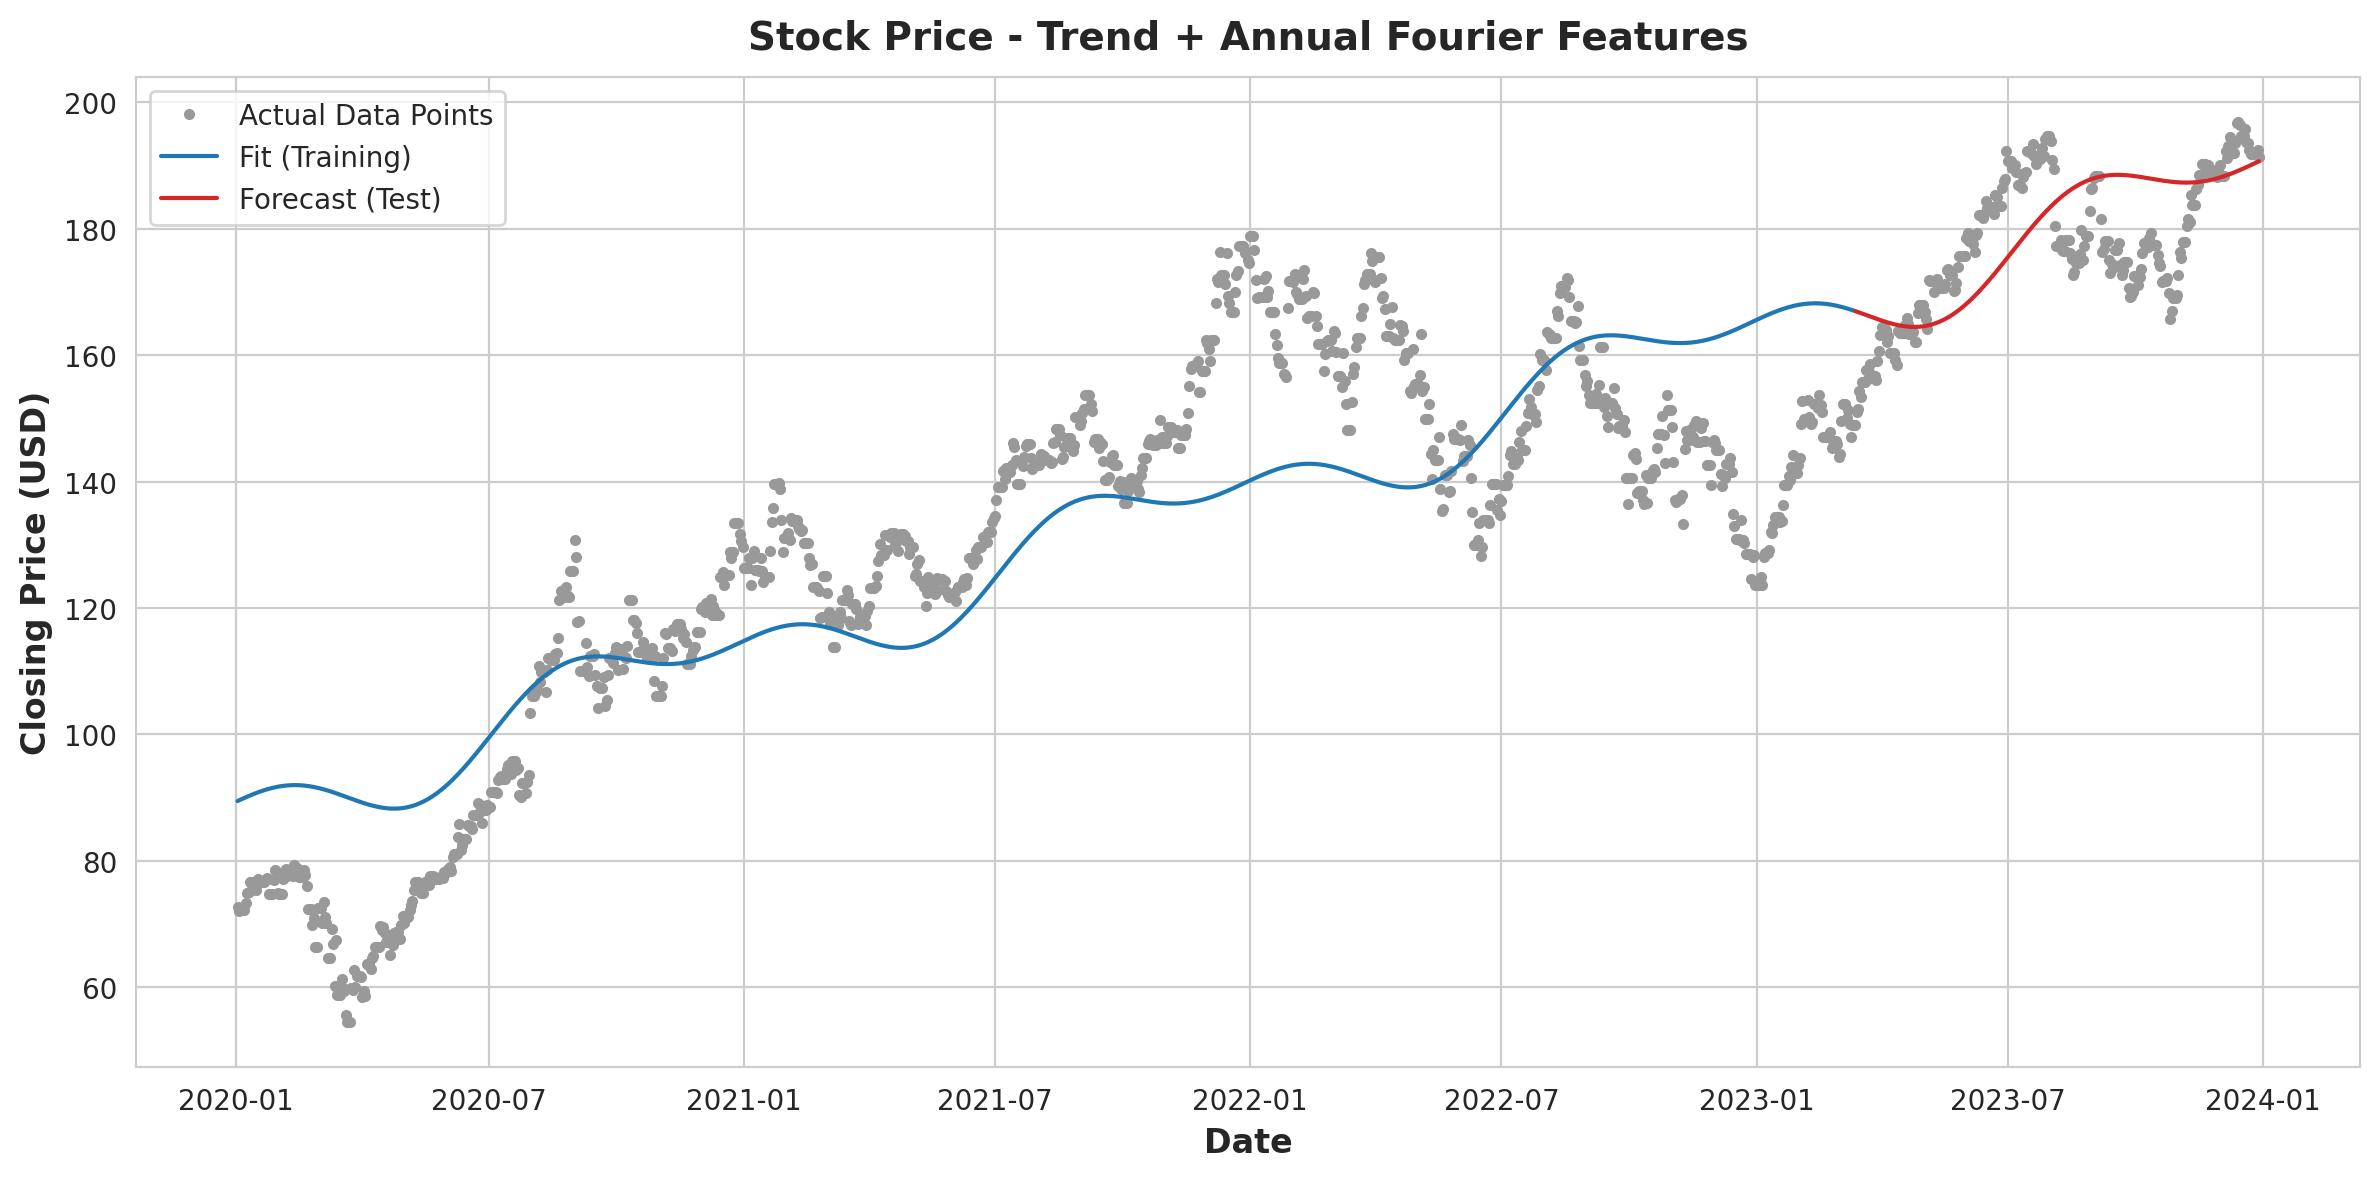

Model evaluation on the test set:
Mean Squared Error (Test): 92.51
Mean Absolute Error (Test): 8.19


In [3]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

# Ensure the index is a DatetimeIndex with a frequency
data.index = pd.to_datetime(data.index)  # Ensure the index is datetime
data = data.asfreq('D')  # Set the frequency to daily ('D')

# Fill missing values in the 'Close' column
data['Close'] = data['Close'].bfill()  # Backward-fill missing values (copies next-in-time value to missing value)

# Define Fourier terms for annual seasonality
fourier = CalendarFourier(freq="A", order=2)  # #order sin/cos pairs for annual seasonality

# Create the DeterministicProcess
dp = DeterministicProcess(
    index=data.index,
    constant=True,               # Add a constant (bias term)
    order=1,                     # Linear trend
    seasonal=False,               # Weekly seasonality
    additional_terms=[fourier],  # Annual seasonality (Fourier terms)
    drop=True,                   # Drop collinear terms
)

# Generate features for the entire dataset
X = dp.in_sample()
y = data['Close']  # Target variable (closing price)

# Train-test split (80% train, 20% test, no shuffling to preserve time order)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train the model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Generate predictions for the training set
y_train_pred = pd.Series(model.predict(X_train).flatten(), index=X_train.index)

# Generate predictions for the test set
y_test_pred = pd.Series(model.predict(X_test).flatten(), index=X_test.index)

# Plot the results
plt.figure(figsize=(12, 6))

# Plot the actual data points
plt.plot(data.index, data['Close'], '.', color='0.6', label="Actual Data Points")

# Plot the training fit
plt.plot(y_train_pred.index, y_train_pred, label="Fit (Training)", color="C0")

# Plot the forecast for the test set
plt.plot(y_test_pred.index, y_test_pred, label="Forecast (Test)", color="C3")

# Add labels, title, and legend
plt.title("Stock Price - Trend + Annual Fourier Features")
plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Evaluate the model on the test set
print("Model evaluation on the test set:")
mse = mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
print(f"Mean Squared Error (Test): {mse:.2f}")
print(f"Mean Absolute Error (Test): {mae:.2f}")

We see that the model with Fourier features performs worst than the simple linear one, with its performance getting poorer for increasing order $k$. We need to find better features.

Let's have a look at some moving averages.

[*********************100%***********************]  1 of 1 completed


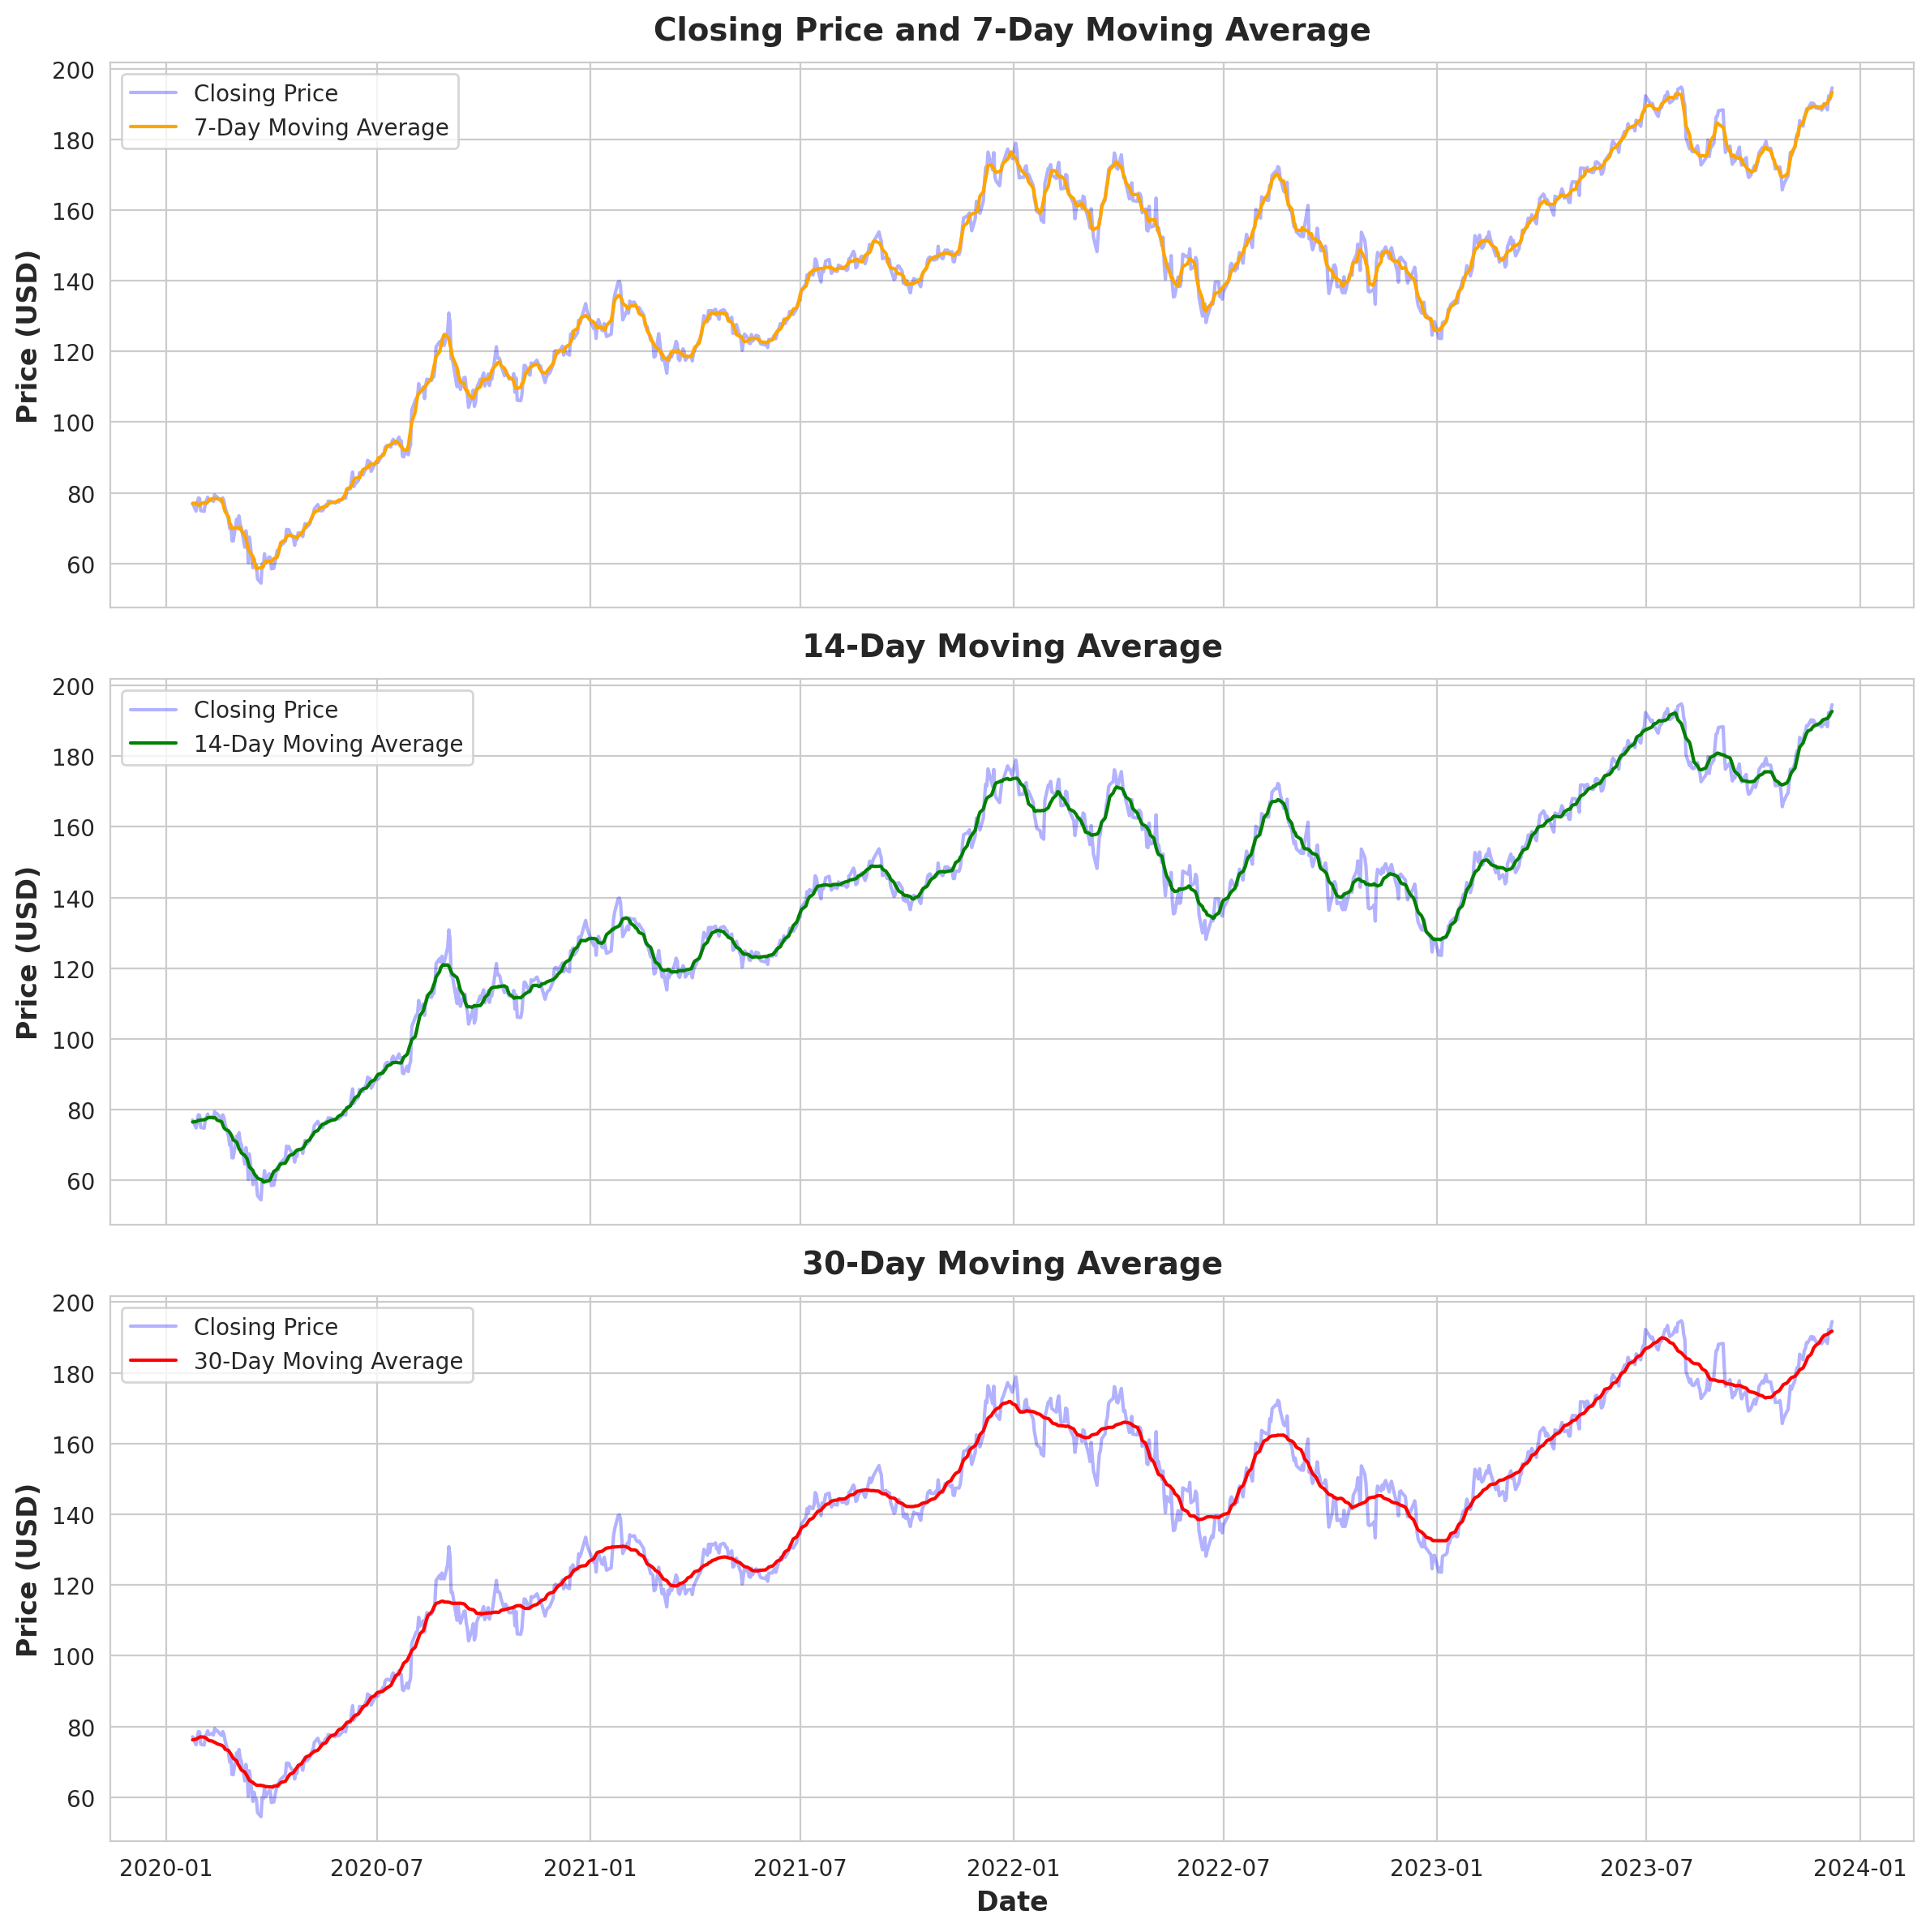

In [4]:
data = yf.download(ticker, start=start_date, end=end_date)

# Create features; moving averages (centered)
data['7_day_MA'] = data['Close'].rolling(window=7, center=True).mean()
data['14_day_MA'] = data['Close'].rolling(window=14, center=True).mean()
data['30_day_MA'] = data['Close'].rolling(window=30, center=True).mean()
data['Daily_Return'] = data['Close'].pct_change()

# Drop NaN values from rolling windows
data.dropna(inplace=True)

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 12), sharex=True)

# Plot closing price and 7-day moving average
axes[0].plot(data.index, data['Close'], label="Closing Price", color="blue", alpha=0.3)
axes[0].plot(data.index, data['7_day_MA'], label="7-Day Moving Average", color="orange")
axes[0].set_title("Closing Price and 7-Day Moving Average")
axes[0].set_ylabel("Price (USD)")
axes[0].grid(True)
axes[0].legend()

# Plot 14-day moving average
axes[1].plot(data.index, data['Close'], label="Closing Price", color="blue", alpha=0.3)
axes[1].plot(data.index, data['14_day_MA'], label="14-Day Moving Average", color="green")
axes[1].set_title("14-Day Moving Average")
axes[1].set_ylabel("Price (USD)")
axes[1].grid(True)
axes[1].legend()

# Plot 30-day moving average
axes[2].plot(data.index, data['Close'], label="Closing Price", color="blue", alpha=0.3)
axes[2].plot(data.index, data['30_day_MA'], label="30-Day Moving Average", color="red")
axes[2].set_title("30-Day Moving Average")
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Price (USD)")
axes[2].grid(True)
axes[2].legend()

# Adjust layout
plt.tight_layout()
plt.show()